# **Download**

In [1]:
!pip install git+https://github.com/pcahan1/oneSC.git@cscb24
!pip install scanpy
!pip install git+https://github.com/CahanLab/PySingleCellNet
!pip install igraph
!pip install adjustText
!pip install -U scFates
!pip install pyslingshot

  Cloning https://github.com/pcahan1/oneSC.git (to revision cscb24) to /tmp/pip-req-build-bc_2lgpd
  Running command git clone --filter=blob:none --quiet https://github.com/pcahan1/oneSC.git /tmp/pip-req-build-bc_2lgpd
  Running command git checkout -b cscb24 --track origin/cscb24
  Switched to a new branch 'cscb24'
  Branch 'cscb24' set up to track remote branch 'cscb24' from 'origin'.
  Resolved https://github.com/pcahan1/oneSC.git to commit 9b0bcef27daeab72e297ece546f57c63ed10820b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 653.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import pySingleCellNet as pySCN
import adjustText
import onesc
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scanpy as sc
import anndata
import scipy as sp
from joblib import dump, load
import sys
import igraph as ig
from igraph import Graph
import scFates as scf
import pyslingshot as pyShot

ig.config['plotting.backend'] = 'matplotlib'
import random
random.seed(24)

#  **Data Pre-processing**

In [58]:
# Read intial data
adata=sc.read_h5ad("/content/adEarly_CSCB24.h5ad")

# Make gene name unique
adata.var_names_make_unique()

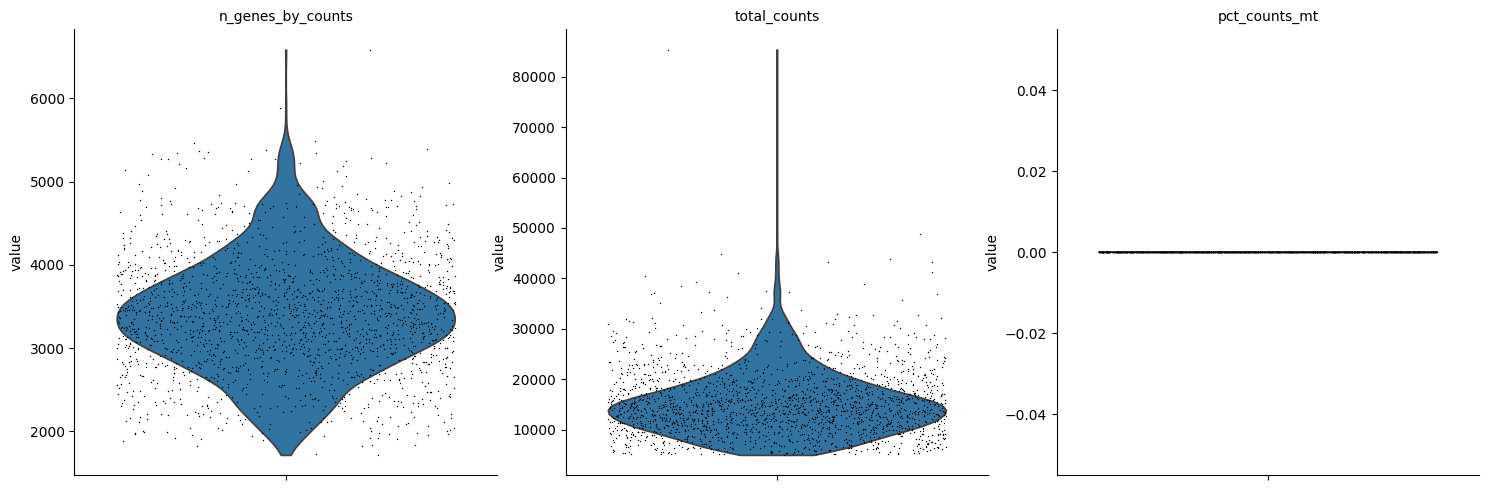

In [59]:
# Filter out the mitochondrion data

# String match to discover mitochondrion genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Genes that encode for ribosomes (could be informative)
ribo_prefix = ("RPS","RPL")
adata.var['ribo'] = adata.var_names.str.startswith(ribo_prefix)

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


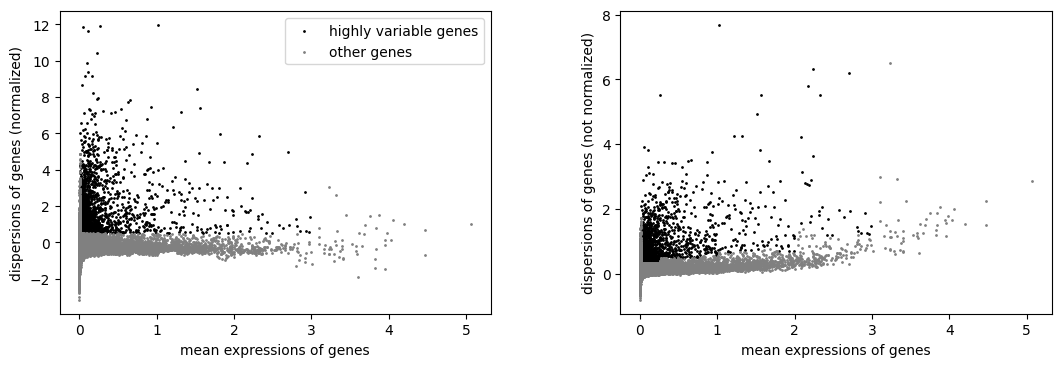

In [60]:
# Removel mt% high cell
adata = adata[adata.obs.pct_counts_mt < 80, :]

# Remove mitochondria genes and ribosomal genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('mt-')]
adata= adata[:, non_mito_genes_list]

non_ribo_genes_list = [name for name in adata.var_names if not name.startswith('Rps')]
adata=adata[:, non_ribo_genes_list]

non_ribo_genes_list = [name for name in adata.var_names if not name.startswith('Rpl')]
adata= adata[:, non_ribo_genes_list]

# Filter low quality gene and cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_cells(adata, max_genes=5500)
sc.pp.filter_cells(adata, max_counts=35000)
sc.pp.filter_genes(adata, min_cells=3)


# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# HVG
sc.pp.highly_variable_genes(adata,min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]

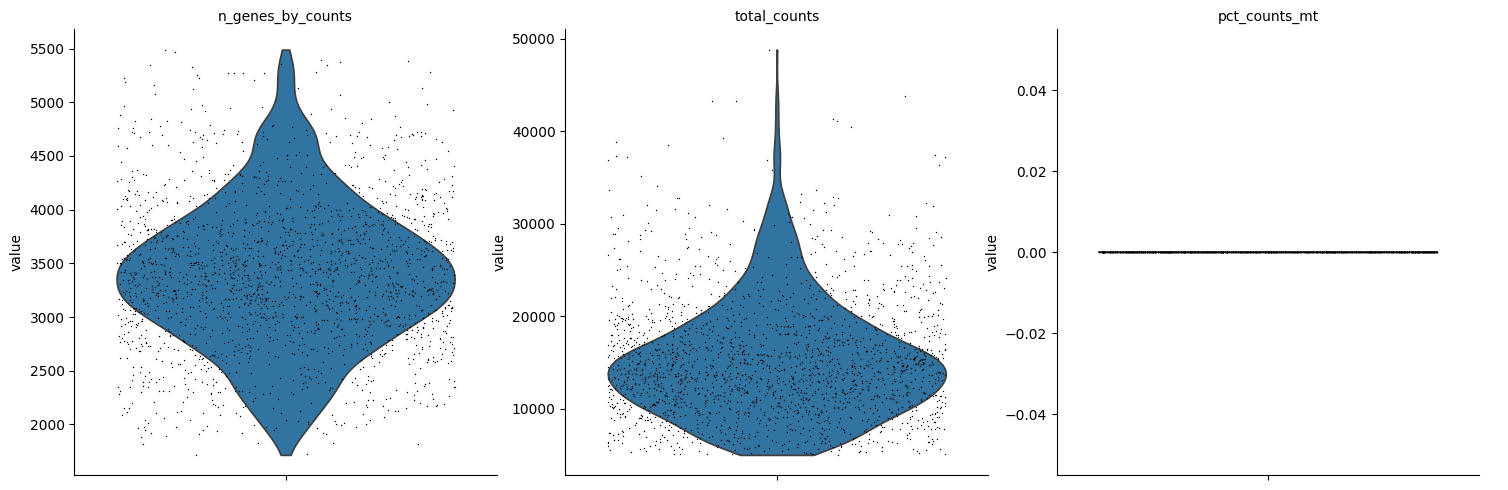

In [61]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


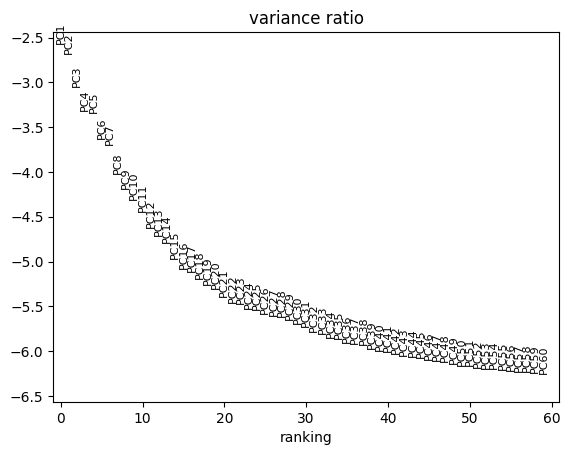

In [62]:
# Find PCA features and compute embedding
sc.tl.pca(adata, n_comps=60, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, 60, log=True)

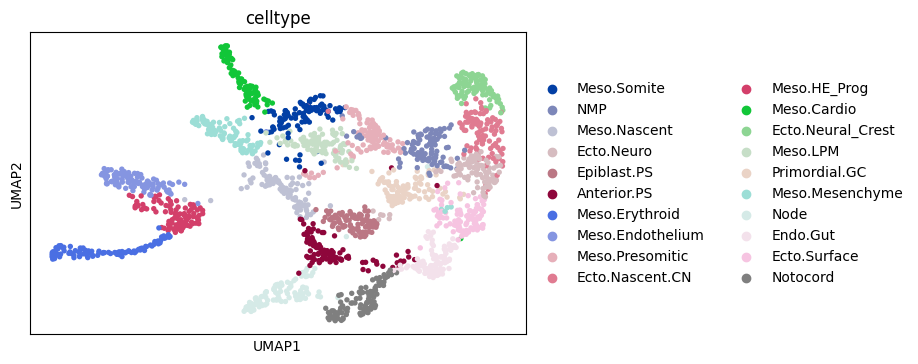

In [63]:
# KNN, displace all cell types given in early adata

sc.pp.neighbors(adata, n_neighbors=60, n_pcs=20)
sc.tl.leiden(adata, resolution=.5)
sc.tl.umap(adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(adata, color=['celltype'])

# **TI Epiblast.PS -> Ecto.Neuro \ Anterior.PS**

In [64]:
# Filter data for epiblast to possible cell types: definitive ectoderm and APS

desired_cell_types = ["Epiblast.PS", "Ecto.Neuro", "Anterior.PS"]
mask = adata.obs['celltype'].isin(desired_cell_types)
filtered_adata = adata[mask]

In [65]:
# Redo PCA
sc.tl.pca(adata, n_comps=60, svd_solver='arpack')
sc.tl.pca(filtered_adata, n_comps= 60, svd_solver='arpack')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


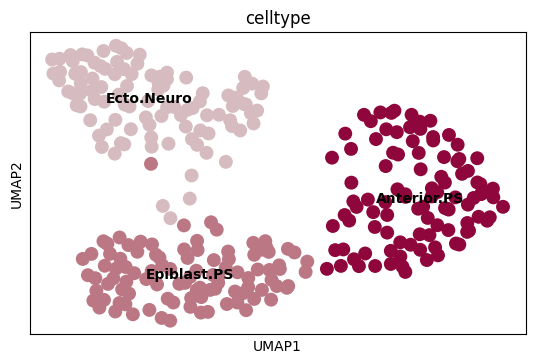

In [66]:
# KNN

sc.pp.neighbors(filtered_adata, n_neighbors= 50, n_pcs=16)
sc.tl.leiden(filtered_adata, resolution=.5)
sc.tl.umap(filtered_adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(filtered_adata, color=['celltype'],legend_loc='on data')

inferring a principal tree --> parameters used 
    50 principal points, sigma = 1, lambda = 10, metric = euclidean
    fitting:  46%|████▌     | 23/50 [00:00<00:00, 78.95it/s] 
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


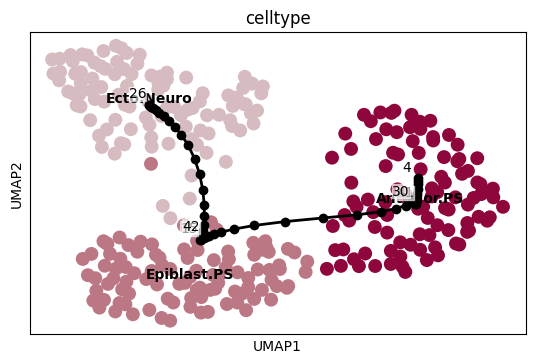

In [67]:
# scFate tree analysis

scf.tl.tree(filtered_adata, method="ppt", Nodes= 50, use_rep="X_pca", ppt_lambda = 10,  ppt_sigma = 1, seed = 1)
scf.pl.graph(filtered_adata, basis='umap', color_cells = 'celltype', legend_loc='on data')

In [68]:
# set root to epiblast cluster

scf.tl.root(filtered_adata, 42) # assigns pseudotime to principal points
scf.tl.pseudotime(filtered_adata) # assigns to each cell a pseudotime value, a segment, and a milestone.

node 42 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


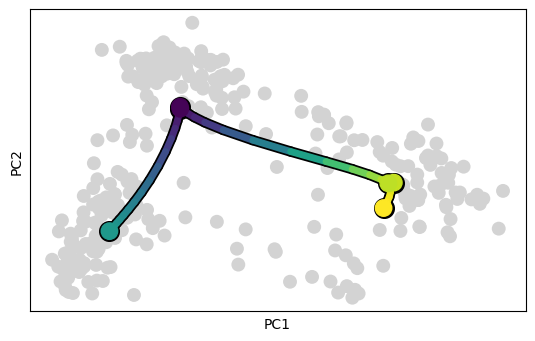

In [69]:
scf.pl.trajectory(filtered_adata, basis = 'pca')

# **DEG**

In [70]:
# filter out only TF genes
adata_flitered_TF = filtered_adata.copy()
adata_flitered_TF.var_names

Index(['Sox17', 'Sgk3', 'Ppp1r42', 'Cpa6', '4930444P10Rik', 'Rdh10', 'Tfap2b',
       'Efhc1', 'Col9a1', 'Ptpn18',
       ...
       'Sfrp5', 'Nkx2-3', 'Cpn1', 'Gm17018', 'Fgf8', 'Ina', 'Eno4', 'Slc18a2',
       'Pdzd8', 'Prdx3'],
      dtype='object', length=1860)

In [18]:
# filter out only TF genes
adata_flitered_TF = filtered_adata.copy()
adata_flitered_TF.var_names

# Read gene names from the text file
file_path = '/content/allTFs_mm_aertslab_011924.txt' # Update with your file path
with open(file_path, 'r') as file:
    file_gene_names = [line.strip() for line in file]

# Assuming 'adata.var_names' contains your current gene names
# Extract gene names from 'adata'
adata_gene_names = list(adata_flitered_TF.var_names)

# Find the intersection of gene names
overlap_genes = set(file_gene_names).intersection(set(adata_gene_names))

# Subset 'adata' to keep only the overlapping genes
adata_flitered_TF = adata_flitered_TF[:, list(overlap_genes)]

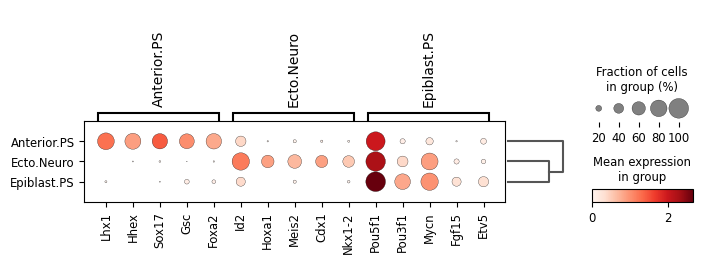

In [22]:
# Differentia gene expression
sc.tl.rank_genes_groups(adata_flitered_TF, use_raw=False, groupby="celltype")
sc.pl.rank_genes_groups_dotplot(adata_flitered_TF, n_genes=5, groupby="celltype", dendrogram=True, key='rank_genes_groups')

according to literature ["Pax6", "Krt8", "Krt18", "Otx2" ] are markers for definitive ectorderm

In [71]:
selected_TF = ["Lhx1", "Hhex", "Sox17", "Gsc", "Foxa2", "Id2", "Hoxa1", "Meis2", "Cdx1", "Nkx1-2",
               "Pou5f1", "Pou3f1", "Mycn", "Fgf15", "Etv5", "Pax6", "Krt8", "Krt18", "Otx2" ]


In [72]:
adata_flitered_TF = adata_flitered_TF[:,selected_TF]

# **scFate**

In [ ]:
# sub-set to hvg and TF to run and limit cells to only epiblast, mesoderm, and endoderm
adata_filtered_clean = filtered_adata.copy()

scf.tl.test_association(filtered_adata)

test features for association with the trajectory
    single mapping : 100%|██████████| 1860/1860 [06:18<00:00,  4.91it/s]
    found 100 significant features (0:06:18) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [ ]:
scf.tl.fit(filtered_adata)

fit features associated with the trajectory
    single mapping : 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:17) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [ ]:
scf.tl.cluster(filtered_adata)
filtered_adata.var.clusters.unique()

Clustering features using fitted layer
    finished (0:00:00) --> added 
    .var['clusters'] identified modules.


['0', '2', '4', '1', '3']
Categories (5, object): ['0', '1', '2', '3', '4']

In [ ]:
# filter out only TF genes
adata_flitered_TF = filtered_adata.copy()
adata_flitered_TF.var_names

# Read gene names from the text file
file_path = '/content/allTFs_mm_aertslab_011924.txt' # Update with your file path
with open(file_path, 'r') as file:
    file_gene_names = [line.strip() for line in file]

# Assuming 'adata.var_names' contains your current gene names
# Extract gene names from 'adata'
adata_gene_names = list(adata_flitered_TF.var_names)

# Find the intersection of gene names
overlap_genes = set(file_gene_names).intersection(set(adata_gene_names))

# Subset 'adata' to keep only the overlapping genes
adata_flitered_TF = adata_flitered_TF[:, list(overlap_genes)]

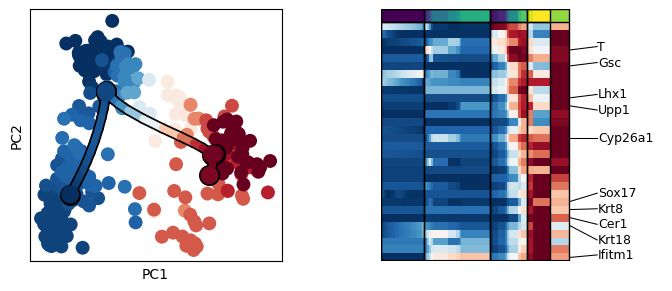

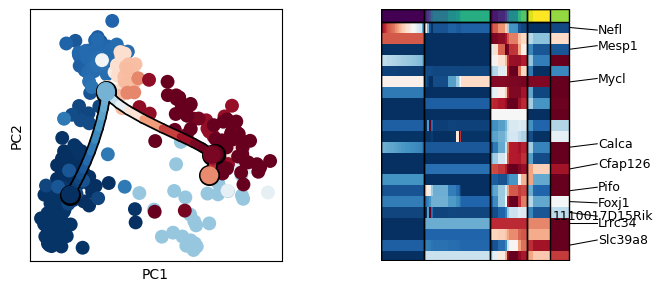

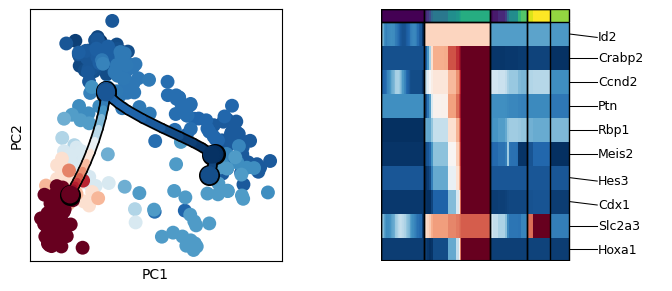

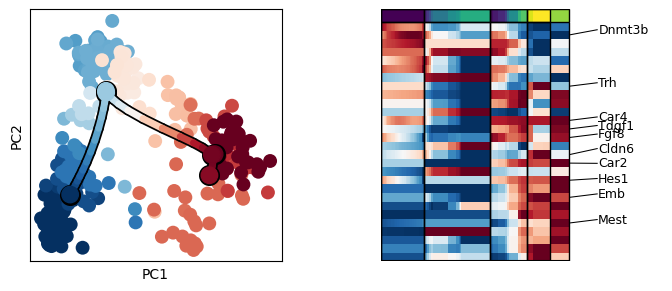

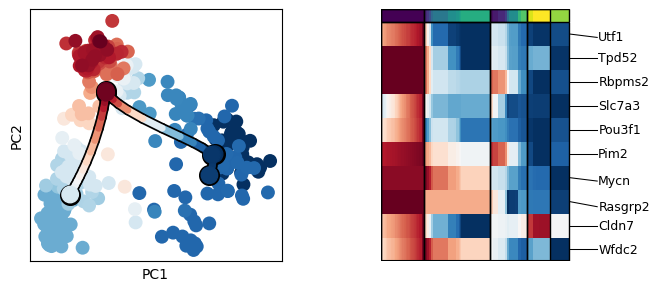

In [ ]:
for c in filtered_adata.var["clusters"].unique():
    scf.pl.trends(filtered_adata,features=filtered_adata.var_names[filtered_adata.var.clusters==c],basis="pca")

# **OneSC**

/usr/local/lib/python3.10/dist-packages/pySingleCellNet/utils.py:779: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cellid"] = adata.obs.index
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Anterior.PS : 
100
Epiblast.PS : 
100
Ecto.Neuro : 
100


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/usr/local/lib/python3.10/dist-packages/pySingleCellNet/rank_class.py:46: ImplicitModificationWarning: Setting element `.obsm['SCN_score']` of view, initializing view as actual.
  adata.obsm['SCN_score'] = xans.copy()
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


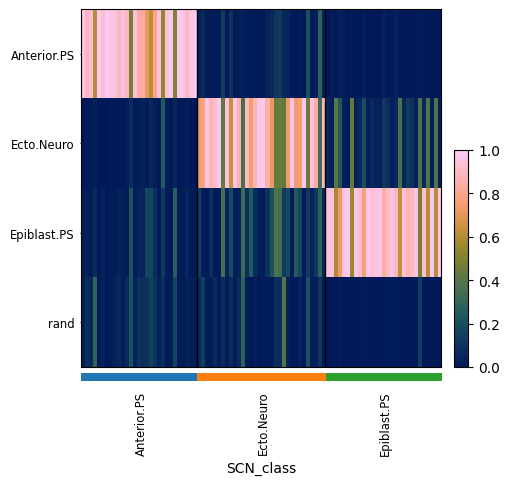

In [73]:
# set pySCN
adTrain_rank, adHeldOut_rank = pySCN.splitCommonAnnData(adata_flitered_TF, ncells= 70,dLevel="celltype")
clf = pySCN.train_rank_classifier(adTrain_rank, dLevel="celltype")

pySCN.rank_classify(adHeldOut_rank, clf)
pySCN.heatmap_scores(adHeldOut_rank, groupby='SCN_class')

In [74]:
initial_clusters = ['Epiblast.PS']
end_clusters = ["Ecto.Neuro", "Anterior.PS"]

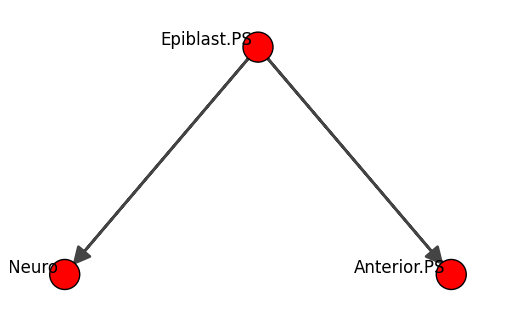

In [75]:
state_path = onesc.construct_cluster_graph_adata(adata_flitered_TF,
                                                 initial_clusters = initial_clusters,
                                                 terminal_clusters = end_clusters,
                                                 cluster_col = "celltype",
                                                 pseudo_col = "t")
onesc.plot_state_graph(state_path)

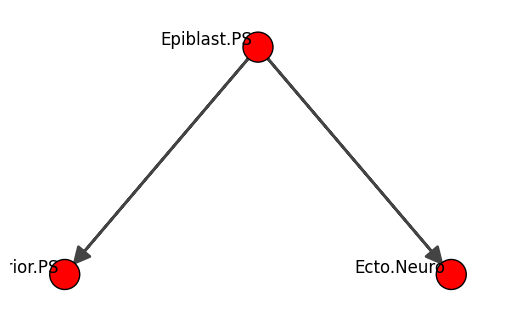

In [76]:
edge_list = [("Epiblast.PS", "Anterior.PS"), ("Epiblast.PS", "Ecto.Neuro")]
H = nx.DiGraph(edge_list)
onesc.plot_state_graph(H)

Preparing states and data for GA ...
Hhex have conflicting states, the below states are deleted
['Epiblast.PS_stable_trajectory_0', 'Epiblast.PS_unstable_trajectory_1']
Sox17 have conflicting states, the below states are deleted
['Epiblast.PS_stable_trajectory_0', 'Epiblast.PS_unstable_trajectory_1']
Gsc have conflicting states, the below states are deleted
['Epiblast.PS_unstable_trajectory_0', 'Epiblast.PS_stable_trajectory_1']
Foxa2 have conflicting states, the below states are deleted
['Epiblast.PS_unstable_trajectory_0', 'Epiblast.PS_stable_trajectory_1']
Id2 have conflicting states, the below states are deleted
['Epiblast.PS_stable_trajectory_0', 'Epiblast.PS_unstable_trajectory_1']
Pou5f1 have conflicting states, the below states are deleted
['Epiblast.PS_stable_trajectory_0', 'Epiblast.PS_unstable_trajectory_1']
Pax6 have conflicting states, the below states are deleted
['Epiblast.PS_stable_trajectory_0', 'Epiblast.PS_unstable_trajectory_1']
Starting network reconstruction with 

/usr/local/lib/python3.10/dist-packages/onesc/genetic_algorithm_GRN_trimming.py:821: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(cpu_count()))
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GRN reconstruction complete.


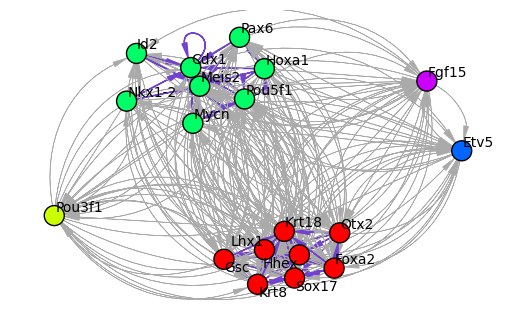

In [78]:
start_end_states = {'start': ['Epiblast.PS'], 'end':["Ecto.Neuro", "Anterior.PS"]}

iGRN = onesc.infer_grn(H,
                       start_end_states,
                       adata_flitered_TF,
                       num_generations = 20,
                       sol_per_pop = 30,
                       reduce_auto_reg=True,
                       ideal_edges = 0,
                       GA_seed_list = [1, 3],
                       init_pop_seed_list = [21, 25],
                       cluster_col='celltype',
                       pseudoTime_col='t')

grn_ig = onesc.dataframe_to_igraph(iGRN)
onesc.plot_grn(grn_ig, layout_method='fr',community_first=True)

# **KO**

In [ ]:
# subset gene to selected TF list
adata_start = adata_flitered_TF[adata_flitered_TF.obs['celltype'] == 'epiblast', :]

# make gene expression to boolean expression
xstates = onesc.define_states_adata(adata_start)

In [ ]:
# set up simulator
netname = 'Epidiff'
netsim = onesc.network_structure()
netsim.fit_grn(iGRN)
sim = onesc.OneSC_simulator()
sim.add_network_compilation(netname, netsim)

In [ ]:
perturb_dict = dict()
perturb_dict['Etv5'] = -1
simlist_Gsc_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

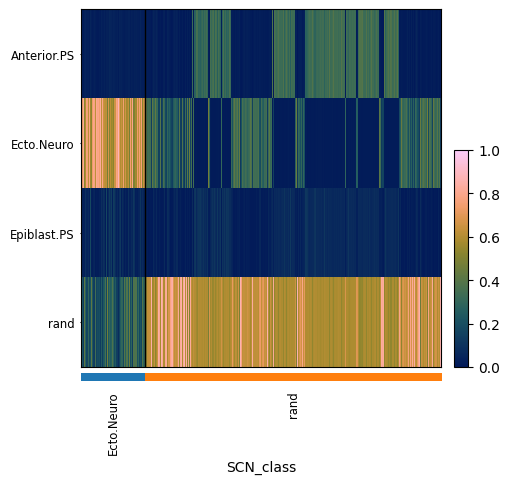

In [ ]:
ad_Gsc_ko = onesc.sample_and_compile_anndatas(simlist_Gsc_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Gsc_ko, clf)
pySCN.heatmap_scores(ad_Gsc_ko, groupby = 'SCN_class')

## **Lhx1 KO: APS enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Lhx1'] = -1
simlist_Lhx1_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

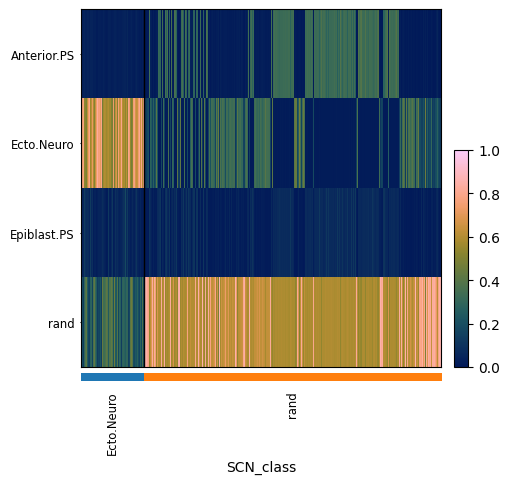

In [ ]:
ad_Lhx1_ko = onesc.sample_and_compile_anndatas(simlist_Lhx1_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Lhx1_ko, clf)
pySCN.heatmap_scores(ad_Lhx1_ko, groupby = 'SCN_class')

## **Foxa2 KO: APS enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Foxa2'] = -1
simlist_Foxa2_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

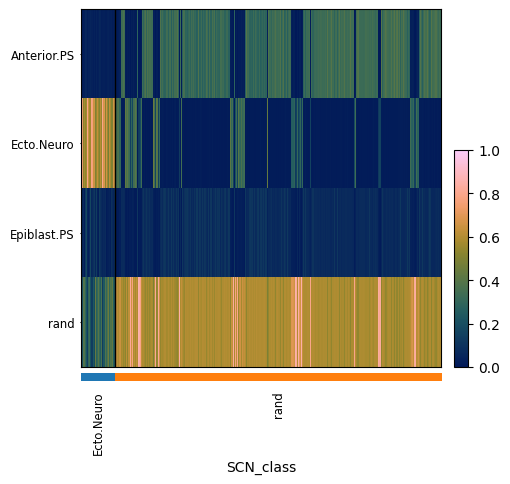

In [ ]:
ad_Foxa2_ko = onesc.sample_and_compile_anndatas(simlist_Foxa2_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Foxa2_ko, clf)
pySCN.heatmap_scores(ad_Foxa2_ko, groupby = 'SCN_class')


## **Sox17 KO: APS enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Sox17'] = -1
simlist_Sox17_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)


/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

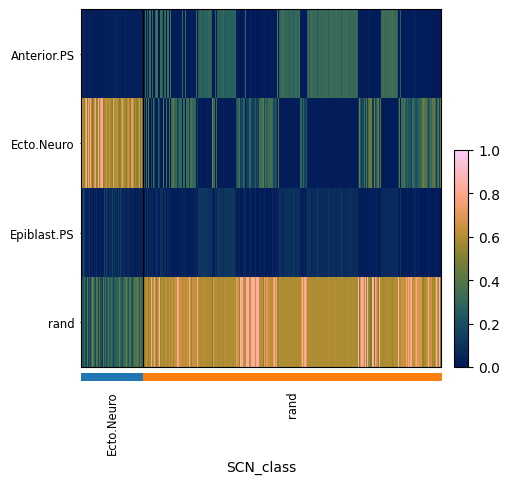

In [ ]:
ad_Sox17_ko = onesc.sample_and_compile_anndatas(simlist_Sox17_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Sox17_ko, clf)
pySCN.heatmap_scores(ad_Sox17_ko, groupby = 'SCN_class')

## **Pou5f1 KO: Epiblast enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Pou5f1'] = -1
simlist_Pou5f1_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)


/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

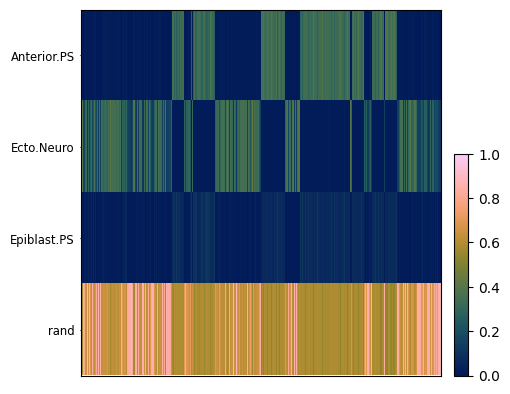

In [ ]:
ad_Pou5f1_ko = onesc.sample_and_compile_anndatas(simlist_Pou5f1_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Pou5f1_ko, clf)
pySCN.heatmap_scores(ad_Pou5f1_ko, groupby = 'SCN_class')

## **Id2 Overexpress: Defin. Ecto. enriched TF**




In [ ]:
perturb_dict = dict()
perturb_dict['Id2'] = 1
simlist_Id2_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

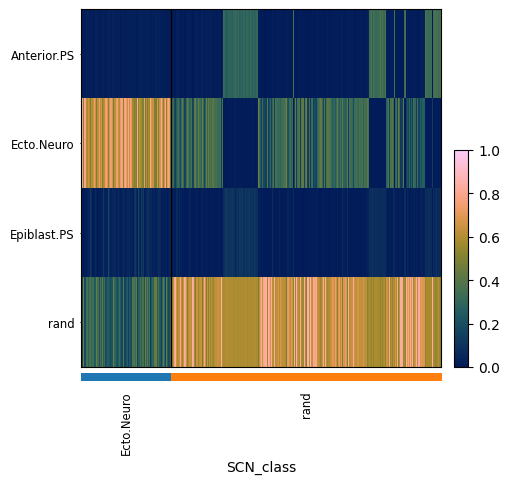

In [ ]:
ad_Id2_ko = onesc.sample_and_compile_anndatas(simlist_Id2_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Id2_ko, clf)
pySCN.heatmap_scores(ad_Id2_ko, groupby = 'SCN_class')

## **Hoxa1 Overexpress: Defin. Ecto. enriched TF**


In [ ]:
perturb_dict = dict()
perturb_dict['Hoxa1'] = 1
simlist_Hoxa1_ko = onesc.simulate_parallel_adata(sim, xstates, 'Epidiff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

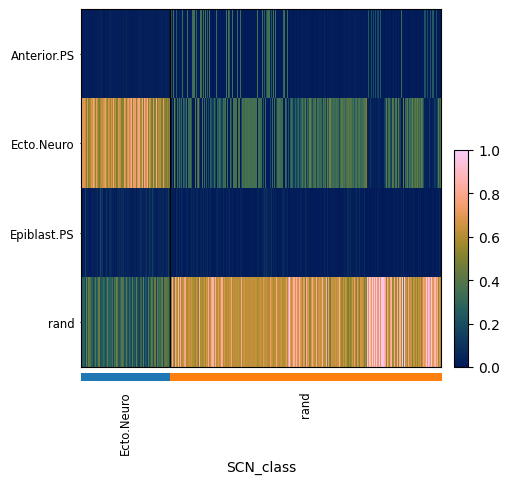

In [ ]:
ad_Hoxa1_ko = onesc.sample_and_compile_anndatas(simlist_Hoxa1_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Hoxa1_ko, clf)
pySCN.heatmap_scores(ad_Hoxa1_ko, groupby = 'SCN_class')

# **Signaling Pathway Reasoning**

Starting with mice epiblast, the first step towards basal keratinocytes is differentiating to definitive ectoderm.
According to our code Final_Epi->Ecto.Neuro.ipynb, the differential expressed gene analysis, we found the top 5 expressed tf genes in both epiblast and definitive ectoderm.

*   APS:"Lhx1", "Hhex", "Sox17", "Gsc", "Foxa2"
*   Ectoderm: "Id2", "Hoxa1", "Meis2", "Cdx1", "Nkx1-2"
*   Epiblast: "Pou5f1", "Pou3f1", "Mycn", "Fgf15", "Etv5"

According to the literature, Pou5f1 is typically expressed at epiblast and its main functionality is to maintain the proliferation of stem cells. BMP is used to maintain the regulation of pou5f1. Blocking BMP will downregulate Pou5f1 and therefore enable epiblast to exist its stem cell niche and start differentiation.

Another gene is Hoxa1 which is also a transcriptional factor that shows importance when overexpressed in Onesc. When OE, it result in a more pure state of definitive ectoderm. Past literature shows that using Retinoic Acid Signaling pathway. It controls the expression of Hoxa1. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6649716/]

In [1]:
%%shell
jupyter nbconvert --to html '/content/Epiblast_to_DefinitiveEctorderm.ipynb'

[NbConvertApp] Converting notebook /content/Epiblast_to_DefinitiveEctorderm.ipynb to html
[NbConvertApp] Writing 2253025 bytes to /content/Epiblast_to_DefinitiveEctorderm.html
